In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
#!pip install dgl -f https://data.dgl.ai/wheels/repo.html
#!pip install dgl-cu111 dglgo -f https://data.dgl.ai/wheels/repo.html
#!pip install dive-into-graphs
#!pip install pydig

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 9.4 MB/s 
     |████████████████████████████████| 3.5 MB 9.9 MB/s 


In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from termcolor import colored
from torch._C import dtype

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import torch_geometric.nn as gnn
import torch.nn.functional as F
from torch.nn import Linear
from sklearn.model_selection import train_test_split
import numpy as np
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
from torch_geometric.datasets import TUDataset
from torch_geometric.data.batch import Batch
from torch import Tensor
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from typing import Callable, Union, Tuple
from torch_sparse import SparseTensor

from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from operator import add
import tensorflow as tf

#. DGL
#import dgl
#import dgl.function as fn
#from dgl.data import GINDataset
#from dgl.nn import GNNExplainer as GNNExplainer_DGL
#from dgl.dataloading import GraphDataLoader
#from dgl.nn import AvgPooling

#. DIG
#from dig.xgraph.dataset import SynGraphDataset
#from dig.xgraph.method import PGExplainer
#from dig.xgraph.utils.compatibility import compatible_state_dict
#from dig.xgraph.method.subgraphx import PlotUtils
#from dig.xgraph.method.subgraphx import MCTS
#from torch_geometric.utils import to_networkx
#from dig.xgraph.method import GNNExplainer as GNNExplainer_DIG
#from dig.xgraph.models import GCN_2l
#from dig.xgraph.models import GlobalMeanPool

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [5]:
Explainability_name = 'LRP'
Task_name = 'Node Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [6]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
#dataset = SynGraphDataset('./datasets', 'BA_shapes')

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
#print(np.shape(dataset))
print(data)
print(colored('===========================================================================================================', 'red'))


# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Number of val nodes: {data.val_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Number of test nodes: 1000
Number of val nodes: 500
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [7]:
print(len(data.x[0]))
print(len(data.x))
print(len(data.y))
print(data.y[0])
print(f'MAX: {max(data.y)}')
print(f'MIN: {min(data.y)}')
print(data.x[0])
print(len(data.edge_index[0]))
print("-------------------------------------")


1433
2708
2708
tensor(3)
MAX: 6
MIN: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])
10556
-------------------------------------


In [8]:
def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool, device=index.device)
    mask[index] = 1
    return mask

In [9]:
def balanced_train_test_split(dataset):
  train_percent = 0.7
  index_list = []
  num_classes = dataset.num_classes

  for i in range(num_classes):
    index = (dataset.data.y == i).nonzero().view(-1)
    index = index[torch.randperm(index.size(0))]
    index_list.append(index)
    
  train_index = torch.cat([category_list[:int(len(category_list) * train_percent)] for category_list in index_list], dim=0)
  test_index = torch.cat([category_list[int(len(category_list) * train_percent):] for category_list in index_list], dim=0)

  train_index = train_index[torch.randperm(train_index.size(0))]
  test_index = test_index[torch.randperm(test_index.size(0))]

  dataset.data.train_mask = index_to_mask(train_index, size=dataset.data.num_nodes)
  dataset.data.test_mask = index_to_mask(test_index, size=dataset.data.num_nodes)
  
  dataset.data, dataset.slices = dataset.collate([dataset.data])

  return dataset

In [10]:
dataset2 = balanced_train_test_split(dataset)
dataset_LRP = dataset2[0]
print(dataset_LRP)
print(len(dataset_LRP))
print(len(dataset_LRP.x[dataset_LRP.train_mask]))
print(len(dataset_LRP.x[dataset_LRP.test_mask]))

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
6
1891
817


# **GCN MODEL**

In [11]:
class GNNPool(nn.Module):
    def __init__(self):
        super().__init__()

In [12]:
class GlobalMeanPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return gnn.global_mean_pool(x, batch)

In [13]:
class IdenticalPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return x

In [14]:
class GNNBasic(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def arguments_read(self, *args, **kwargs):

        data: Batch = kwargs.get('data') or None

        if not data:
            if not args:
                assert 'x' in kwargs
                assert 'edge_index' in kwargs
                x, edge_index = kwargs['x'], kwargs['edge_index'],
                batch = kwargs.get('batch')
                if batch is None:
                    batch = torch.zeros(kwargs['x'].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 2:
                x, edge_index = args[0], args[1]
                batch = torch.zeros(args[0].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 3:
                x, edge_index, batch = args[0], args[1], args[2]
            else:
                raise ValueError(f"forward's args should take 2 or 3 arguments but got {len(args)}")
        else:
            x, edge_index, batch = data.x, data.edge_index, data.batch

        return x, edge_index, batch


In [15]:
class GCNConv(gnn.GCNConv):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_weight = None
        self.weight = nn.Parameter(self.lin.weight.data.T.clone().detach())

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        """"""

        if self.normalize and edge_weight is None:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    edge_index, edge_weight = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    edge_index = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        edge_weight.requires_grad_(True)

        x = torch.matmul(x, self.weight)

        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)

        if self.bias is not None:
            out += self.bias

        self.edge_weight = edge_weight

        return out

    def propagate(self, edge_index: Adj, size: Size = None, **kwargs):
        size = self.__check_input__(edge_index, size)

        # Run "fused" message and aggregation (if applicable).
        if (isinstance(edge_index, SparseTensor) and self.fuse
                and not self._explain):
            coll_dict = self.__collect__(self.__fused_user_args__, edge_index,
                                         size, kwargs)

            msg_aggr_kwargs = self.inspector.distribute(
                'message_and_aggregate', coll_dict)
            out = self.message_and_aggregate(edge_index, **msg_aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)

        elif isinstance(edge_index, Tensor) or not self.fuse:
            coll_dict = self.__collect__(self.__user_args__, edge_index, size,
                                         kwargs)

            msg_kwargs = self.inspector.distribute('message', coll_dict)
            out = self.message(**msg_kwargs)

            if self._explain:
                edge_mask = self.__edge_mask__
                if out.size(self.node_dim) != edge_mask.size(0):
                    loop = edge_mask.new_ones(size[0])
                    edge_mask = torch.cat([edge_mask, loop], dim=0)
                assert out.size(self.node_dim) == edge_mask.size(0)
                out = out * edge_mask.view([-1] + [1] * (out.dim() - 1))

            aggr_kwargs = self.inspector.distribute('aggregate', coll_dict)
            out = self.aggregate(out, **aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)


In [16]:
class GCN_2l_Model(GNNBasic):

    def __init__(self, model_level, dim_node, dim_hidden, dim_output):
        super().__init__()
        num_layer = 2

        self.gconv1 = GCNConv(dim_node, dim_hidden)
        self.relu1 = nn.ReLU() 
        
        self.gconv2 = GCNConv(dim_hidden, dim_hidden)
        self.relu2 = nn.ReLU()

        if model_level == 'node':
            self.readout = IdenticalPool()
        else:
            self.readout = GlobalMeanPool()

        self.ffn = nn.Linear(dim_hidden, dim_output)

        self.dropout = nn.Dropout()

    def forward(self, *args, **kwargs) -> torch.Tensor:
        """
        :param Required[data]: Batch - input data
        :return:
        """
        x, edge_index, batch = self.arguments_read(*args, **kwargs)

        post_conv1 = self.relu1(self.gconv1(x, edge_index))
        #out_readout1 = self.readout(post_conv1, batch)
        #print(np.shape(out_readout1))
        post_conv2 = self.relu2(self.gconv2(post_conv1, edge_index))
        out_readout = self.readout(post_conv2, batch)

        #print(np.shape(out_readout))
        out = self.ffn(out_readout)

        return out, post_conv2, post_conv1

    def get_emb(self, *args, **kwargs) -> torch.Tensor:
        x, edge_index, batch = self.arguments_read(*args, **kwargs)
        
        post_conv1 = self.relu1(self.gconv1(x, edge_index))
        post_conv2 = self.relu2(self.gconv2(x, edge_index))
            
        return post_conv2

In [17]:
GCN_Model = GCN_2l_Model(model_level='node', dim_node=1433, dim_hidden=100, dim_output=7)
print(GCN_Model)
#GCN_Model = GCN(16)
GCN_Model.eval()

out, post_conv2, post_conv1 = GCN_Model(dataset_LRP.x, dataset_LRP.edge_index)
#visualize(out, color=data.y)


GCN_2l_Model(
  (gconv1): GCNConv(1433, 100)
  (relu1): ReLU()
  (gconv2): GCNConv(100, 100)
  (relu2): ReLU()
  (readout): IdenticalPool()
  (ffn): Linear(in_features=100, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [18]:
GCN_Model_Optimizer = torch.optim.Adam(GCN_Model.parameters(), lr=0.01, weight_decay=5e-4)

In [19]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch


In [20]:
def loading_model(load_index):
  GCN_Model = GCN_2l_Model(model_level='node', dim_node=1433, dim_hidden=100, num_classes=7)
  GCN_Model_Optimizer = torch.optim.Adam(params = GCN_Model.parameters(), lr=0.01)
  checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/model_classifier"+str(load_index)+".pt")
  GCN_Model.load_state_dict(checkpoint['model_state_dict'])
  GCN_Model.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return GCN_Model, GCN_Model_Optimizer, epoch

In [21]:
def visualize_losses(gcn_losses, epoch_history):
  gcn_losses_list = torch.stack(gcn_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("`GCN Model Loss in Epoch: " + str(epoch_history))
  ax.plot(gcn_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  

# **Traning Configurations**

In [22]:
def train_step():
  GCN_Model.train(True)

  GCN_Model_Optimizer.zero_grad()  
  GCN_Model_out, post_conv2, post_conv1 = GCN_Model(dataset_LRP.x, dataset_LRP.edge_index)  

  GCN_Model_loss = loss_calculations(GCN_Model_out[dataset_LRP.train_mask], dataset_LRP.y[dataset_LRP.train_mask])  
  GCN_Model_loss.backward(retain_graph=True)

  GCN_Model_Optimizer.step()    


  return GCN_Model_loss


In [23]:
LOSS_Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [24]:
def train(EPOCHS, load_index):
  GCN_Model_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    GCN_Model_training_loss= train_step()
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GCN_Model_training_loss:.4f}')

    GCN_Model_training_loss_per_epoch.append(GCN_Model_training_loss)

    #break

    if (epoch + load_index + 1) % LOSS_Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(GCN_Model_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GCN_Model.state_dict(), 'optimizer_state_dict': GCN_Model_Optimizer.state_dict(), 'loss': GCN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier" + str(epoch + load_index + 1)+".pt")

  
  #return model_loss




Epoch: 001, LRP Model Loss: 1.9677
Epoch: 002, LRP Model Loss: 1.9527
Epoch: 003, LRP Model Loss: 1.9278
Epoch: 004, LRP Model Loss: 1.8918
Epoch: 005, LRP Model Loss: 1.8499
Epoch: 006, LRP Model Loss: 1.8194
Epoch: 007, LRP Model Loss: 1.8228
Epoch: 008, LRP Model Loss: 1.8122
Epoch: 009, LRP Model Loss: 1.7837
Epoch: 010, LRP Model Loss: 1.7625
Epoch: 011, LRP Model Loss: 1.7498
Epoch: 012, LRP Model Loss: 1.7357
Epoch: 013, LRP Model Loss: 1.7143
Epoch: 014, LRP Model Loss: 1.6836
Epoch: 015, LRP Model Loss: 1.6447
Epoch: 016, LRP Model Loss: 1.6014
Epoch: 017, LRP Model Loss: 1.5575
Epoch: 018, LRP Model Loss: 1.5127
Epoch: 019, LRP Model Loss: 1.4633
Epoch: 020, LRP Model Loss: 1.4123
Epoch: 021, LRP Model Loss: 1.3607
Epoch: 022, LRP Model Loss: 1.3064
Epoch: 023, LRP Model Loss: 1.2516
Epoch: 024, LRP Model Loss: 1.1985
Epoch: 025, LRP Model Loss: 1.1487
Epoch: 026, LRP Model Loss: 1.1040
Epoch: 027, LRP Model Loss: 1.0610
Epoch: 028, LRP Model Loss: 1.0218
Epoch: 029, LRP Mode

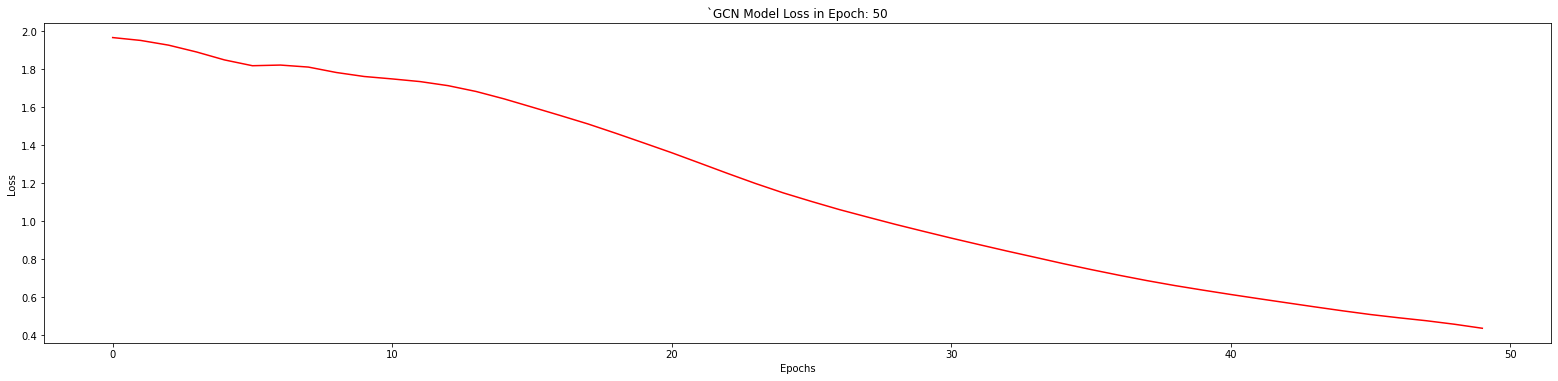

Epoch: 051, LRP Model Loss: 0.4197
Epoch: 052, LRP Model Loss: 0.4080
Epoch: 053, LRP Model Loss: 0.3929
Epoch: 054, LRP Model Loss: 0.3765
Epoch: 055, LRP Model Loss: 0.3641
Epoch: 056, LRP Model Loss: 0.3544
Epoch: 057, LRP Model Loss: 0.3435
Epoch: 058, LRP Model Loss: 0.3316
Epoch: 059, LRP Model Loss: 0.3216
Epoch: 060, LRP Model Loss: 0.3124
Epoch: 061, LRP Model Loss: 0.3040
Epoch: 062, LRP Model Loss: 0.2960
Epoch: 063, LRP Model Loss: 0.2871
Epoch: 064, LRP Model Loss: 0.2787
Epoch: 065, LRP Model Loss: 0.2721
Epoch: 066, LRP Model Loss: 0.2670
Epoch: 067, LRP Model Loss: 0.2611
Epoch: 068, LRP Model Loss: 0.2529
Epoch: 069, LRP Model Loss: 0.2458
Epoch: 070, LRP Model Loss: 0.2410
Epoch: 071, LRP Model Loss: 0.2356
Epoch: 072, LRP Model Loss: 0.2290
Epoch: 073, LRP Model Loss: 0.2231
Epoch: 074, LRP Model Loss: 0.2194
Epoch: 075, LRP Model Loss: 0.2159
Epoch: 076, LRP Model Loss: 0.2109
Epoch: 077, LRP Model Loss: 0.2062
Epoch: 078, LRP Model Loss: 0.2033
Epoch: 079, LRP Mode

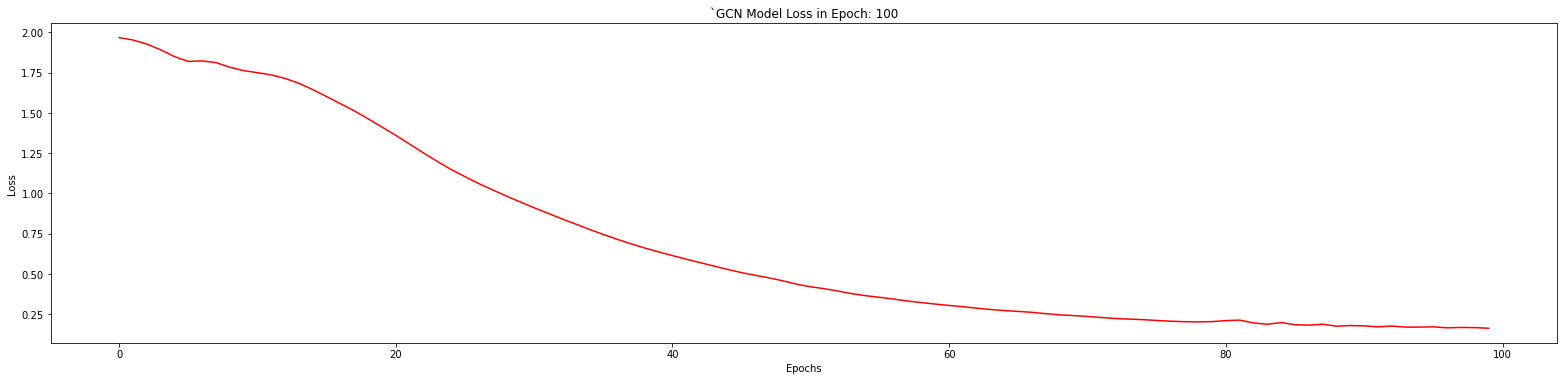

Epoch: 101, LRP Model Loss: 0.1647
Epoch: 102, LRP Model Loss: 0.1619
Epoch: 103, LRP Model Loss: 0.1600
Epoch: 104, LRP Model Loss: 0.1615
Epoch: 105, LRP Model Loss: 0.1585
Epoch: 106, LRP Model Loss: 0.1578
Epoch: 107, LRP Model Loss: 0.1583
Epoch: 108, LRP Model Loss: 0.1558
Epoch: 109, LRP Model Loss: 0.1555
Epoch: 110, LRP Model Loss: 0.1557
Epoch: 111, LRP Model Loss: 0.1537
Epoch: 112, LRP Model Loss: 0.1533
Epoch: 113, LRP Model Loss: 0.1534
Epoch: 114, LRP Model Loss: 0.1518
Epoch: 115, LRP Model Loss: 0.1512
Epoch: 116, LRP Model Loss: 0.1513
Epoch: 117, LRP Model Loss: 0.1501
Epoch: 118, LRP Model Loss: 0.1494
Epoch: 119, LRP Model Loss: 0.1495
Epoch: 120, LRP Model Loss: 0.1491
Epoch: 121, LRP Model Loss: 0.1485
Epoch: 122, LRP Model Loss: 0.1486
Epoch: 123, LRP Model Loss: 0.1483
Epoch: 124, LRP Model Loss: 0.1470
Epoch: 125, LRP Model Loss: 0.1461
Epoch: 126, LRP Model Loss: 0.1456
Epoch: 127, LRP Model Loss: 0.1448
Epoch: 128, LRP Model Loss: 0.1441
Epoch: 129, LRP Mode

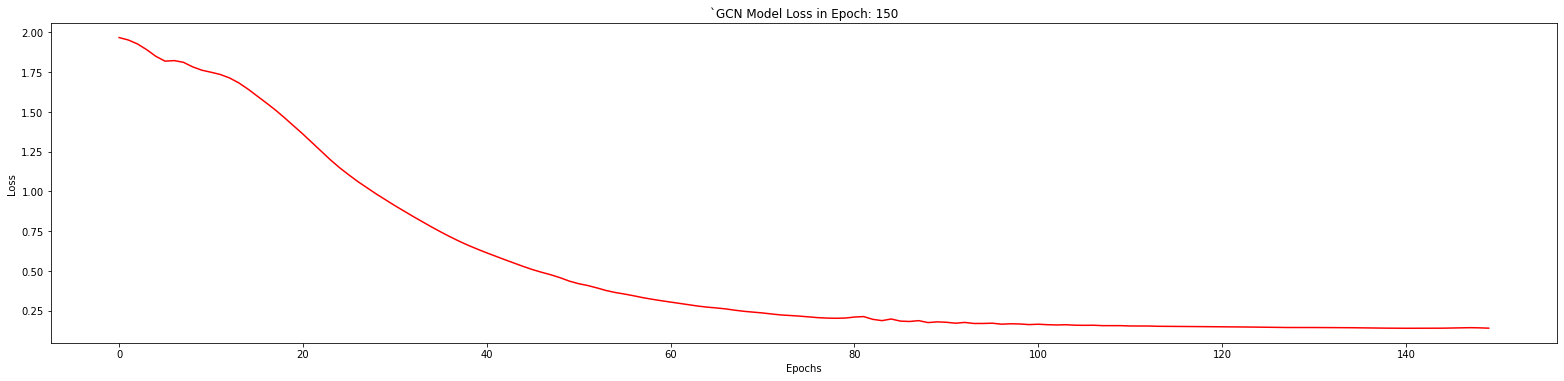

Epoch: 151, LRP Model Loss: 0.1376
Epoch: 152, LRP Model Loss: 0.1362
Epoch: 153, LRP Model Loss: 0.1356
Epoch: 154, LRP Model Loss: 0.1362
Epoch: 155, LRP Model Loss: 0.1374
Epoch: 156, LRP Model Loss: 0.1375
Epoch: 157, LRP Model Loss: 0.1361
Epoch: 158, LRP Model Loss: 0.1343
Epoch: 159, LRP Model Loss: 0.1336
Epoch: 160, LRP Model Loss: 0.1340
Epoch: 161, LRP Model Loss: 0.1344
Epoch: 162, LRP Model Loss: 0.1346
Epoch: 163, LRP Model Loss: 0.1346
Epoch: 164, LRP Model Loss: 0.1349
Epoch: 165, LRP Model Loss: 0.1349
Epoch: 166, LRP Model Loss: 0.1344
Epoch: 167, LRP Model Loss: 0.1337
Epoch: 168, LRP Model Loss: 0.1334
Epoch: 169, LRP Model Loss: 0.1333
Epoch: 170, LRP Model Loss: 0.1328
Epoch: 171, LRP Model Loss: 0.1318
Epoch: 172, LRP Model Loss: 0.1311
Epoch: 173, LRP Model Loss: 0.1313
Epoch: 174, LRP Model Loss: 0.1318
Epoch: 175, LRP Model Loss: 0.1322
Epoch: 176, LRP Model Loss: 0.1324
Epoch: 177, LRP Model Loss: 0.1327
Epoch: 178, LRP Model Loss: 0.1336
Epoch: 179, LRP Mode

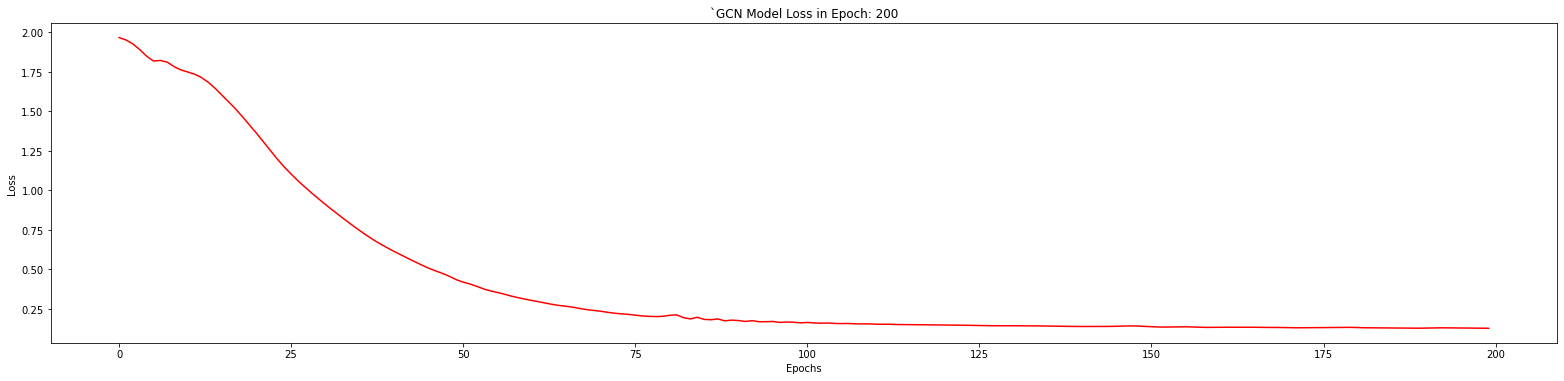

In [25]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  GCN_Model, GCN_Model_Optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [26]:
def GCN_Model_test():
  GCN_Model.eval()
  GCN_Model_out, post_conv2, post_conv1 = GCN_Model(dataset_LRP.x, dataset_LRP.edge_index)
  GCN_Model_pred = GCN_Model_out.argmax(dim=1) 
  GCN_Model_test_correct = GCN_Model_pred[dataset_LRP.test_mask] == dataset_LRP.y[dataset_LRP.test_mask] 
  GCN_Model_test_acc = int(GCN_Model_test_correct.sum()) / int(dataset_LRP.test_mask.sum())
  return GCN_Model_test_acc

In [27]:
GCN_Model_test_acc = GCN_Model_test()
print(f'Test Accuracy: {GCN_Model_test_acc:.4f}')

Test Accuracy: 0.8715


In [28]:
GCN_Model.eval()

GCN_Model_test_out, post_conv2, post_conv1 = GCN_Model(dataset_LRP.x, dataset_LRP.edge_index)
#visualize(GCN_Model_test_out, color = dataset_PGExplainer.y)

## **LayerWise Relevence Propagation**

In [29]:
GCN_Model_state = GCN_Model.state_dict()
print(GCN_Model_state.keys())

odict_keys(['gconv1.bias', 'gconv1.weight', 'gconv1.lin.weight', 'gconv2.bias', 'gconv2.weight', 'gconv2.lin.weight', 'ffn.weight', 'ffn.bias'])


In [30]:
print(GCN_Model.gconv1.weight.detach().clone().shape)

torch.Size([1433, 100])


In [31]:
def GCN_Model_LRP(dataset):
  GCN_Model.eval()
  GCN_Model_out, post_conv2, post_conv1 = GCN_Model(dataset.x, dataset.edge_index)
  return GCN_Model_out.detach().tolist(), post_conv2.detach().tolist(), post_conv1.detach().tolist()

In [32]:
FFN_activations, GConv2_activations, GConv1_activations = GCN_Model_LRP(dataset_LRP)
print(np.shape(FFN_activations))
print(np.shape(GConv2_activations))
print(np.shape(GConv1_activations))

(2708, 7)
(2708, 100)
(2708, 100)


In [33]:
print(len(GConv1_activations))
print(len(GConv1_activations[0]))

2708
100


In [34]:
def accumulate_weights(model_for_you):

  gconv1_bias = model_for_you.gconv1.bias.detach().tolist()
  gconv1_weight = model_for_you.gconv1.weight.detach().tolist()

  gconv2_bias = model_for_you.gconv2.bias.detach().tolist()
  gconv2_weight = model_for_you.gconv2.weight.detach().tolist()

  ffn_bias = model_for_you.ffn.bias.detach().tolist()
  ffn_weight = model_for_you.ffn.weight.detach().tolist()

  

  return gconv1_weight, gconv1_bias, gconv2_weight, gconv2_bias, ffn_weight, ffn_bias

In [35]:
GConv1_weight, GConv1_bias, GConv2_weight, GConv2_bias, FFN_weight, FFN_bias = accumulate_weights(GCN_Model)

In [36]:
GConv1_weight_T = np.array(GConv1_weight).transpose()
GConv1_weight_T = GConv1_weight_T.tolist()
print(np.shape(GConv1_weight_T))

(100, 1433)


In [37]:
GConv2_weight_T = np.array(GConv2_weight).transpose()
GConv2_weight_T = GConv2_weight_T.tolist()
print(np.shape(GConv2_weight_T))

(100, 100)


In [38]:
FFN_weight_T = np.array(FFN_weight).transpose()
FFN_weight_T = FFN_weight_T.tolist()
print(np.shape(FFN_weight_T))

(100, 7)


In [39]:
GConv1_weight = GConv1_weight.copy()
GConv2_weight = GConv2_weight.copy()
FFN_weight = FFN_weight.copy()

In [40]:
a = np.array([[1., 2.], [3., 4.], [5, 6]])
print(a)


b=a[::-1]
print(b)

[[1. 2.]
 [3. 4.]
 [5. 6.]]
[[5. 6.]
 [3. 4.]
 [1. 2.]]


In [41]:
def Compute_R_K(FFN_activations):
  last_layer_R_k = [0] * len(FFN_activations)
  last_layer_R_k[FFN_activations.index(max(FFN_activations))] = FFN_activations[FFN_activations.index(max(FFN_activations))]
  return last_layer_R_k

In [42]:
def Compute_R_J(preceding_layer_activations, exceding_layer_weights, last_layer_R_k):
  SUM_Denominator = 0
  for j in range(len(preceding_layer_activations)):
    for k in range(len(exceding_layer_weights[j])):
      SUM_Denominator = SUM_Denominator + preceding_layer_activations[j] * exceding_layer_weights[j][k]
  print("Denominator is done: ", SUM_Denominator)

  Numerator = []
  for j in range(len(preceding_layer_activations)):
    SUM_Nominator = 0
    for k in range(len(exceding_layer_weights[j])):
      SUM_Nominator = SUM_Nominator + preceding_layer_activations[j] * exceding_layer_weights[j][k] * last_layer_R_k[k]
    Numerator.append(SUM_Nominator)

  R_Js = [x / SUM_Denominator for x in Numerator]
  return R_Js

In [53]:
def One_Sample_LRP(input_sample, weights, activations):
  GConv1_weight = weights[0]
  GConv1_weight_T = weights[1]

  GConv2_weight = weights[2]
  GConv2_weight_T = weights[3]

  FFN_weight = weights[4]
  FFN_weight_T = weights[5]

  GConv1_activations = activations[0]
  GConv2_activations = activations[1]
  FFN_activations = activations[2]
  last_layer_R_k = Compute_R_K(FFN_activations)
  print("R_K: ",last_layer_R_k)
  R_J_hidden2 = Compute_R_J(GConv2_activations, FFN_weight_T, last_layer_R_k)
  print(R_J_hidden2)
  print(len(R_J_hidden2))
  R_J_hidden1 = Compute_R_J(GConv1_activations, GConv2_weight, R_J_hidden2)
  print(R_J_hidden1)
  print(len(R_J_hidden1))
  R_J_input = Compute_R_J(input_sample, GConv1_weight, R_J_hidden1)
  print(R_J_input)
  print(len(R_J_input))  
  
  
  return R_J_input

In [44]:
print(np.shape(GConv1_weight), np.shape(GConv2_weight), np.shape(FFN_weight_T))
print(np.shape(GConv1_weight_T), np.shape(GConv2_weight_T), np.shape(FFN_weight))

(1433, 100) (100, 100) (100, 7)
(100, 1433) (100, 100) (7, 100)


In [45]:
print(np.shape(dataset_LRP.x), np.shape(GConv1_activations), np.shape(GConv2_activations), np.shape(FFN_activations))

torch.Size([2708, 1433]) (2708, 100) (2708, 100) (2708, 7)


In [55]:
sample = 0
LRPs = One_Sample_LRP(dataset_LRP.x[sample].detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[sample], GConv2_activations[sample], FFN_activations[sample]])

R_K:  [0, 0, 0, 5.2494587898254395, 0, 0, 0]
Denominator is done:  -15.758188652541635
[0.056644339655469236, 0.2813052407100738, -0.0, -0.0, -0.04306733994020062, -0.05001918712390364, -0.0, 0.19639860709542856, -0.0, 0.1454274680688383, -0.08402072314853859, -0.0, -0.05939634633057061, -0.04827020904262407, -0.07848046242537372, -0.0, -0.11520339549211896, -0.0562153566568464, -0.0, -0.03990127609595475, -0.0, -0.01181738439139044, -0.008562209148750728, -0.04572422200800064, -0.08035719194984645, 0.26420989386467436, -0.04774260099653747, -0.052813720851256435, -0.051503504940019894, -0.0, -0.0, -0.03141528761045922, -0.048401230176610154, -0.04834273118997077, -0.01918809009956314, -0.0, -0.025377852885086604, -0.08808250220385624, -0.008595143704884928, -0.027561753939112695, -0.0, -0.0, 0.0021657787636804623, -0.08036460351020083, -0.13967837675888825, 0.056651190212214576, 0.04552178652266294, -0.07441311341666879, -0.04331389414593699, -0.10328972019170327, -0.03904970008963485

In [51]:
def LRP_Relevance_Node_Features(LRP, sample):
  fig1 = plt.figure(figsize=(20,40))

  ax1 = plt.subplot2grid((7, 1), (0, 0), colspan=7)
  plt.xlabel("Node Attributes")
  plt.ylabel('Layer-wise Relevance Propagation')
  plt.title("LRP generated for sample: " + str(sample) + "where the GNN is trained on " + str(EPOCHS) + " Epochs")
  
  ax1.plot(LRP, color='r')
  print('done')
  
  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "LRP generated for sample number: " + str(sample) + ".png")
  plt.show()

done


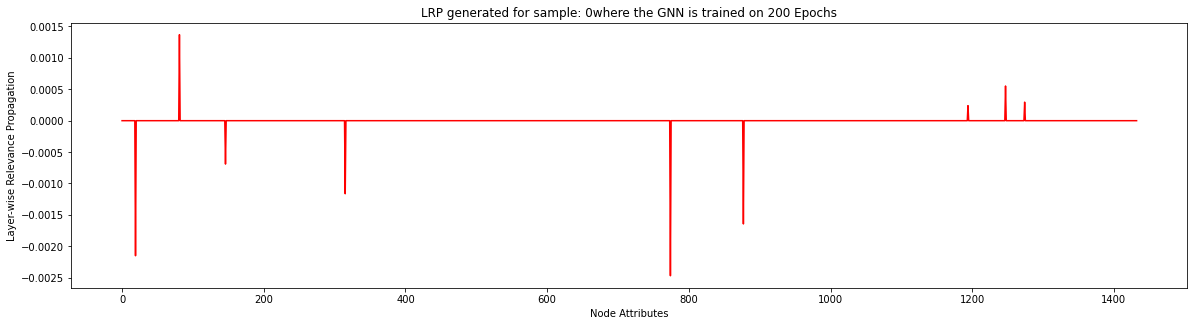

In [56]:
LRP_Relevance_Node_Features(LRPs, sample)

## **Class based averaging on Relevances**

In [58]:
Train_Index_List = []
for i in range(len(dataset_LRP.train_mask)):
  if dataset_LRP.train_mask[i]:
    Train_Index_List.append(i)

Test_Index_List = []
for i in range(len(dataset_LRP.test_mask)):
  if dataset_LRP.test_mask[i]:
    Test_Index_List.append(i)

In [57]:
Node_Index_Class1 = []
Node_Index_Class2 = []
Node_Index_Class3 = []
Node_Index_Class4 = []
Node_Index_Class5 = []
Node_Index_Class6 = []
Node_Index_Class7 = []

In [59]:
for i in range(len(Test_Index_List)):
  if dataset_LRP.y[Test_Index_List[i]] == 0:
    Node_Index_Class1.append(Test_Index_List[i])
  elif dataset_LRP.y[Test_Index_List[i]] == 1:
    Node_Index_Class2.append(Test_Index_List[i])
  elif dataset_LRP.y[Test_Index_List[i]] == 2:
    Node_Index_Class3.append(Test_Index_List[i])
  elif dataset_LRP.y[Test_Index_List[i]] == 3:
    Node_Index_Class4.append(Test_Index_List[i])
  elif dataset_LRP.y[Test_Index_List[i]] == 4:
    Node_Index_Class5.append(Test_Index_List[i])
  elif dataset_LRP.y[Test_Index_List[i]] == 5:
    Node_Index_Class6.append(Test_Index_List[i])
  elif dataset_LRP.y[Test_Index_List[i]] == 6:
    Node_Index_Class7.append(Test_Index_List[i])

In [60]:
print(len(Node_Index_Class1), len(Node_Index_Class2), len(Node_Index_Class3), len(Node_Index_Class4), len(Node_Index_Class5), len(Node_Index_Class6), len(Node_Index_Class7))

106 66 126 246 128 90 55


In [61]:
LRPs_Class1 = []
LRPs_Class2 = []
LRPs_Class3 = []
LRPs_Class4 = []
LRPs_Class5 = []
LRPs_Class6 = []
LRPs_Class7 = []

## **LRP of samples in each Class**

In [62]:
for index in Node_Index_Class1:
  LRPs_Class1.append(One_Sample_LRP(dataset_LRP.x[index].detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[index], GConv2_activations[index], FFN_activations[index]]))

R_K:  [7.687158584594727, 0, 0, 0, 0, 0, 0]
Denominator is done:  -4.702099707254182
[0.4041689055508307, -1.3837435893100771, -0.0, -0.0, -0.21427594659966465, -0.06715662288485899, -0.0, -0.35415950838356575, -0.0, -0.378301546898709, -0.0, -0.0, -0.0, -0.05096025597755106, -0.0, -0.0, -0.0, -0.0, -0.0, -0.36119167668414964, -0.0, -0.0, -0.7807351952125038, -0.0029219131818512445, -0.0, -0.2020909891852578, -0.0, -0.06372918434543158, -0.0, -0.0, -0.0, -0.0, -0.10303416130106641, -0.0052528149817646485, -0.3534359326424283, -0.0, -0.040808360502875694, -0.0, -0.30949714545628887, -0.2658670902311254, -0.0, -0.0, 0.09793038062684091, -0.0, -0.047322145494613506, 0.8914051181737381, -0.0, -0.0, -0.1483381952641365, -0.000384438363678035, 0.04076005361043304, -0.0, 0.17774748620767966, -0.0, 0.2046824953992065, -2.5193067054636544, -0.0, -0.0077078033004278875, -1.411528573623222, -0.0, -0.0, -0.0, -0.0, -0.32737301201394897, -0.0972532680768934, 0.0014749404743039055, -0.0, -0.03957350

In [63]:
for index in Node_Index_Class2:
  LRPs_Class2.append(One_Sample_LRP(dataset_LRP.x[index].detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[index], GConv2_activations[index], FFN_activations[index]]))

R_K:  [0, 8.446847915649414, 0, 0, 0, 0, 0]
Denominator is done:  -6.609061451266122
[0.09823506734666823, -1.1296859782786692, -0.0, -0.0, 0.04765741076864965, 0.024173257818863564, -0.0, 0.6861166162565564, -0.0, 0.39322896403929275, 0.1408816932786248, -0.0, 0.007416300961645977, 0.004812760383935111, -0.0660626941213232, -0.0, -0.38094362262745757, -0.0, -0.0, 0.04261791698393656, -0.0, -0.422598678228128, 0.17331962197796166, 0.01011317452742608, -0.13652529830032914, -0.8655475918890383, -0.0, 0.024307633020721687, 0.029954421205300945, -0.0, -0.0, -0.26596344775169395, 0.024695981472989795, -0.0, 0.24187175079248213, -0.0, 0.22090947715792916, -0.16139781725564661, -1.107844754506968, 0.08486347114243051, -0.0, -0.0, 0.14431102063450837, -0.24447076914507643, -0.8370744930031012, 0.7407679236429908, 0.3450342865961064, -0.5219675000944204, 0.03994533444985778, -0.39715030593559886, -0.0, -0.0, 0.20430995412059524, -0.45374452359411893, 0.4779902537727013, -2.001793494472848, -0.

In [64]:
for index in Node_Index_Class3:
  LRPs_Class3.append(One_Sample_LRP(dataset_LRP.x[index].detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[index], GConv2_activations[index], FFN_activations[index]]))

R_K:  [0, 0, 6.931436061859131, 0, 0, 0, 0]
Denominator is done:  -11.774257980594385
[-0.3539588947048774, 0.4918408320203989, -0.0, -0.0, 0.030541190264340295, 0.02463408627194381, -0.0, 0.39242307548624716, -0.0, 0.2653342307012343, -0.25423726845469297, -0.0, -0.17000943352269618, 0.06008223147199144, -0.3401029696475188, -0.0, -0.26334054326766804, -0.0052192008974928815, -0.0, 0.04310462302182036, -0.0, -0.23277261591401788, 0.1048416457969007, 0.0438479737519304, -0.17728070211273672, -0.06951900403391433, -0.05609118187555547, 0.05993004479290697, -0.3202485086679838, -0.0, -0.0, -0.27999387971370165, 0.026395361391551023, 0.04742968654876239, 0.09030112850355086, -0.0, 0.11145610307715215, -0.2833940085876537, -0.04683579473624092, 0.03650438880101535, -0.0, -0.0, -0.2932638176516193, -0.25994896432390635, -0.10866586625005227, 0.000865468300746489, -0.41467564407458557, -0.27863010676513816, 0.03196619284354618, -0.1391487292451182, 0.05236558732588219, -0.0, -0.3754762781921

In [65]:
for index in Node_Index_Class4:
  LRPs_Class4.append(One_Sample_LRP(dataset_LRP.x[index].detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[index], GConv2_activations[index], FFN_activations[index]]))

Output hidden; open in https://colab.research.google.com to view.

In [66]:
for index in Node_Index_Class5:
  LRPs_Class5.append(One_Sample_LRP(dataset_LRP.x[index].detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[index], GConv2_activations[index], FFN_activations[index]]))

R_K:  [0, 0, 0, 0, 7.606878280639648, 0, 0]
Denominator is done:  -20.00834930467092
[0.059229423707283374, 0.29276743465902383, -0.0, -0.0, -0.1076693223460209, -0.07446759265175036, -0.0, -0.1420413216066757, -0.0, -0.016310034508529924, -0.008540034601443305, -0.0, 0.025915041481246244, -0.19063537556655258, 0.04610805668793167, -0.0, 0.07854037950646788, -0.16620865075775984, -0.0, -0.09221331394247424, -0.0, 0.003887446594931399, -0.1529541807516235, -0.16597633195984465, 0.0221018284084771, 0.26703242586310455, -0.06421305923600286, -0.16635768517975058, -0.2719582407067091, -0.0, -0.0, 0.021822424202861485, -0.08793980358683674, -0.16121456532662734, -0.24398152517803243, -0.0, -0.2649942432172533, 0.07606725609371061, 0.04129149950563489, -0.1649167005853216, -0.0, -0.0, -0.20053790062113144, 0.07283831108566627, 0.08738167706562296, -0.13245749896725212, 0.02632742269773907, 0.0447240066934211, -0.0919611260934123, 0.06441254036186102, -0.14748071152076145, -0.0, -0.2046924240

In [67]:
for index in Node_Index_Class6:
  LRPs_Class6.append(One_Sample_LRP(dataset_LRP.x[index].detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[index], GConv2_activations[index], FFN_activations[index]]))

R_K:  [0, 0, 0, 0, 0, 9.551542282104492, 0]
Denominator is done:  -7.043140272193215
[-1.3796232149854155, -0.9110087835903068, -0.0, -0.0, -0.0, -0.0, -0.0, -0.585651628920821, -0.0, -0.3412489662478984, 0.06944475874551695, -0.0, 0.11004498030360749, 0.03492148601140315, -0.17753707676395822, -0.0, 0.1708156346210129, 0.09780360991380019, -0.0, -0.0, -0.0, -0.3360392909673857, 0.054235268598789944, 0.03941277694232831, 0.11495343166056811, -1.3524853436349151, 0.09596851392671224, 0.04412034053135685, -0.1875715648088233, -0.0, -0.0, -0.5355964512444997, -0.0, 0.023808017762487452, 0.13352995527687053, -0.0, 0.18076022815831225, 0.07251955646856241, -0.016097443430215175, -0.0, -0.0, -0.0, -1.0954534344844966, 0.04847474408852033, -0.0, -1.032059248064054, -1.6127583461077877, -0.1808905863801923, -0.0, 0.06773139358267427, 0.05512158022182419, -0.0, -1.6645563396814103, 0.10161780752881171, -0.32452179918151136, -0.6632552078347516, -0.0, -0.264267211917349, 0.1497445933439189, -0.3

In [68]:
for index in Node_Index_Class7:
  LRPs_Class7.append(One_Sample_LRP(dataset_LRP.x[index].detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[index], GConv2_activations[index], FFN_activations[index]]))

R_K:  [0, 0, 0, 0, 3.192084312438965, 0, 0]
Denominator is done:  -9.008119162391202
[0.07767182071659667, 0.27731673045305827, -0.0, -0.0, -0.05046243426958245, -0.02629321814770388, -0.0, -0.12392184794094888, -0.0, -0.014896316386050601, -0.003020347585315048, -0.0, -0.0, -0.08544554737321902, 0.016350408576725123, -0.0, 0.026832872752130966, -0.0676788315203744, -0.0, -0.05199720975128137, -0.0, 0.00947659944312553, -0.09810843020933104, -0.06697892095027322, -0.0, 0.2717925689903907, -0.021093806243183806, -0.07858344105714309, -0.12419566209809396, -0.0, -0.0, 0.021148932014773077, -0.03503516073152707, -0.06796544170259657, -0.14809415172520884, -0.0, -0.15898848116447017, 0.027261440700771522, 0.06677147459101344, -0.06941458226019788, -0.0, -0.0, -0.13714758014482364, 0.026643730669439373, 0.0304886876345616, -0.11903175460453787, 0.02785994981561683, 0.019373209305338215, -0.037625352431671526, 0.020616314925730326, -0.06681456090859263, -0.0, -0.1532669466188584, 0.019262557

## **Average Relevances in all Classes**

In [69]:
Average_LRPs_Class1 = np.mean(LRPs_Class1, axis=0)
Average_LRPs_Class2 = np.mean(LRPs_Class2, axis=0)
Average_LRPs_Class3 = np.mean(LRPs_Class3, axis=0)
Average_LRPs_Class4 = np.mean(LRPs_Class4, axis=0)
Average_LRPs_Class5 = np.mean(LRPs_Class5, axis=0)
Average_LRPs_Class6 = np.mean(LRPs_Class6, axis=0)
Average_LRPs_Class7 = np.mean(LRPs_Class7, axis=0)

In [70]:
print(len(Average_LRPs_Class1))

1433


## **PLOT Average Relevances**

In [71]:
def Averaged_LRP_Relevance_Classes(LRP):
  fig1 = plt.figure(figsize=(20,40))

  ax1 = plt.subplot2grid((7, 1), (0, 0), colspan=7)
  plt.xlabel("Nodes' Attributes")
  plt.ylabel('Layer-wise Relevance Propagation')
  plt.title("Dimensionally Averaged LRPs for Class: One, where the GNN is trained on " + str(EPOCHS) + " Epochs")

  ax2 = plt.subplot2grid((7, 1), (1, 0), colspan=7)
  plt.xlabel("Nodes' Attributes")
  plt.ylabel('Layer-wise Relevance Propagation')
  plt.title("Dimensionally Averaged LRPs for Class: Two, where the GNN is trained on " + str(EPOCHS) + " Epochs") 

  ax3 = plt.subplot2grid((7, 1), (2, 0), colspan=7)
  plt.xlabel("Nodes' Attributes")
  plt.ylabel('Layer-wise Relevance Propagation')
  plt.title("Dimensionally Averaged LRPs for Class: Three, where the GNN is trained on " + str(EPOCHS) + " Epochs")

  ax4 = plt.subplot2grid((7, 1), (3, 0), colspan=7)
  plt.xlabel("Nodes' Attributes")
  plt.ylabel('Layer-wise Relevance Propagation')
  plt.title("Dimensionally Averaged LRPs for Class: Four, where the GNN is trained on " + str(EPOCHS) + " Epochs")

  ax5 = plt.subplot2grid((7, 1), (4, 0), colspan=7)
  plt.xlabel("Nodes' Attributes")
  plt.ylabel('Layer-wise Relevance Propagation')
  plt.title("Dimensionally Averaged LRPs for Class: Five, where the GNN is trained on " + str(EPOCHS) + " Epochs")

  ax6 = plt.subplot2grid((7, 1), (5, 0), colspan=7)
  plt.xlabel("Nodes' Attributes")
  plt.ylabel('Layer-wise Relevance Propagation')
  plt.title("Dimensionally Averaged LRPs for Class: Six, where the GNN is trained on " + str(EPOCHS) + " Epochs")

  ax7 = plt.subplot2grid((7, 1), (6, 0), colspan=7)
  plt.xlabel("Nodes' Attributes")
  plt.ylabel('Layer-wise Relevance Propagation')
  plt.title("Dimensionally Averaged LRPs for Class: Seven, where the GNN is trained on " + str(EPOCHS) + " Epochs")

  ax1.plot(LRP[0], color='r')
  ax2.plot(LRP[1], color='r')
  ax3.plot(LRP[2], color='r')
  ax4.plot(LRP[3], color='r')
  ax5.plot(LRP[4], color='r')
  ax6.plot(LRP[5], color='r')
  ax7.plot(LRP[6], color='r')  

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Dimensionally Averaged LRPs for Classes.png")
  plt.show()

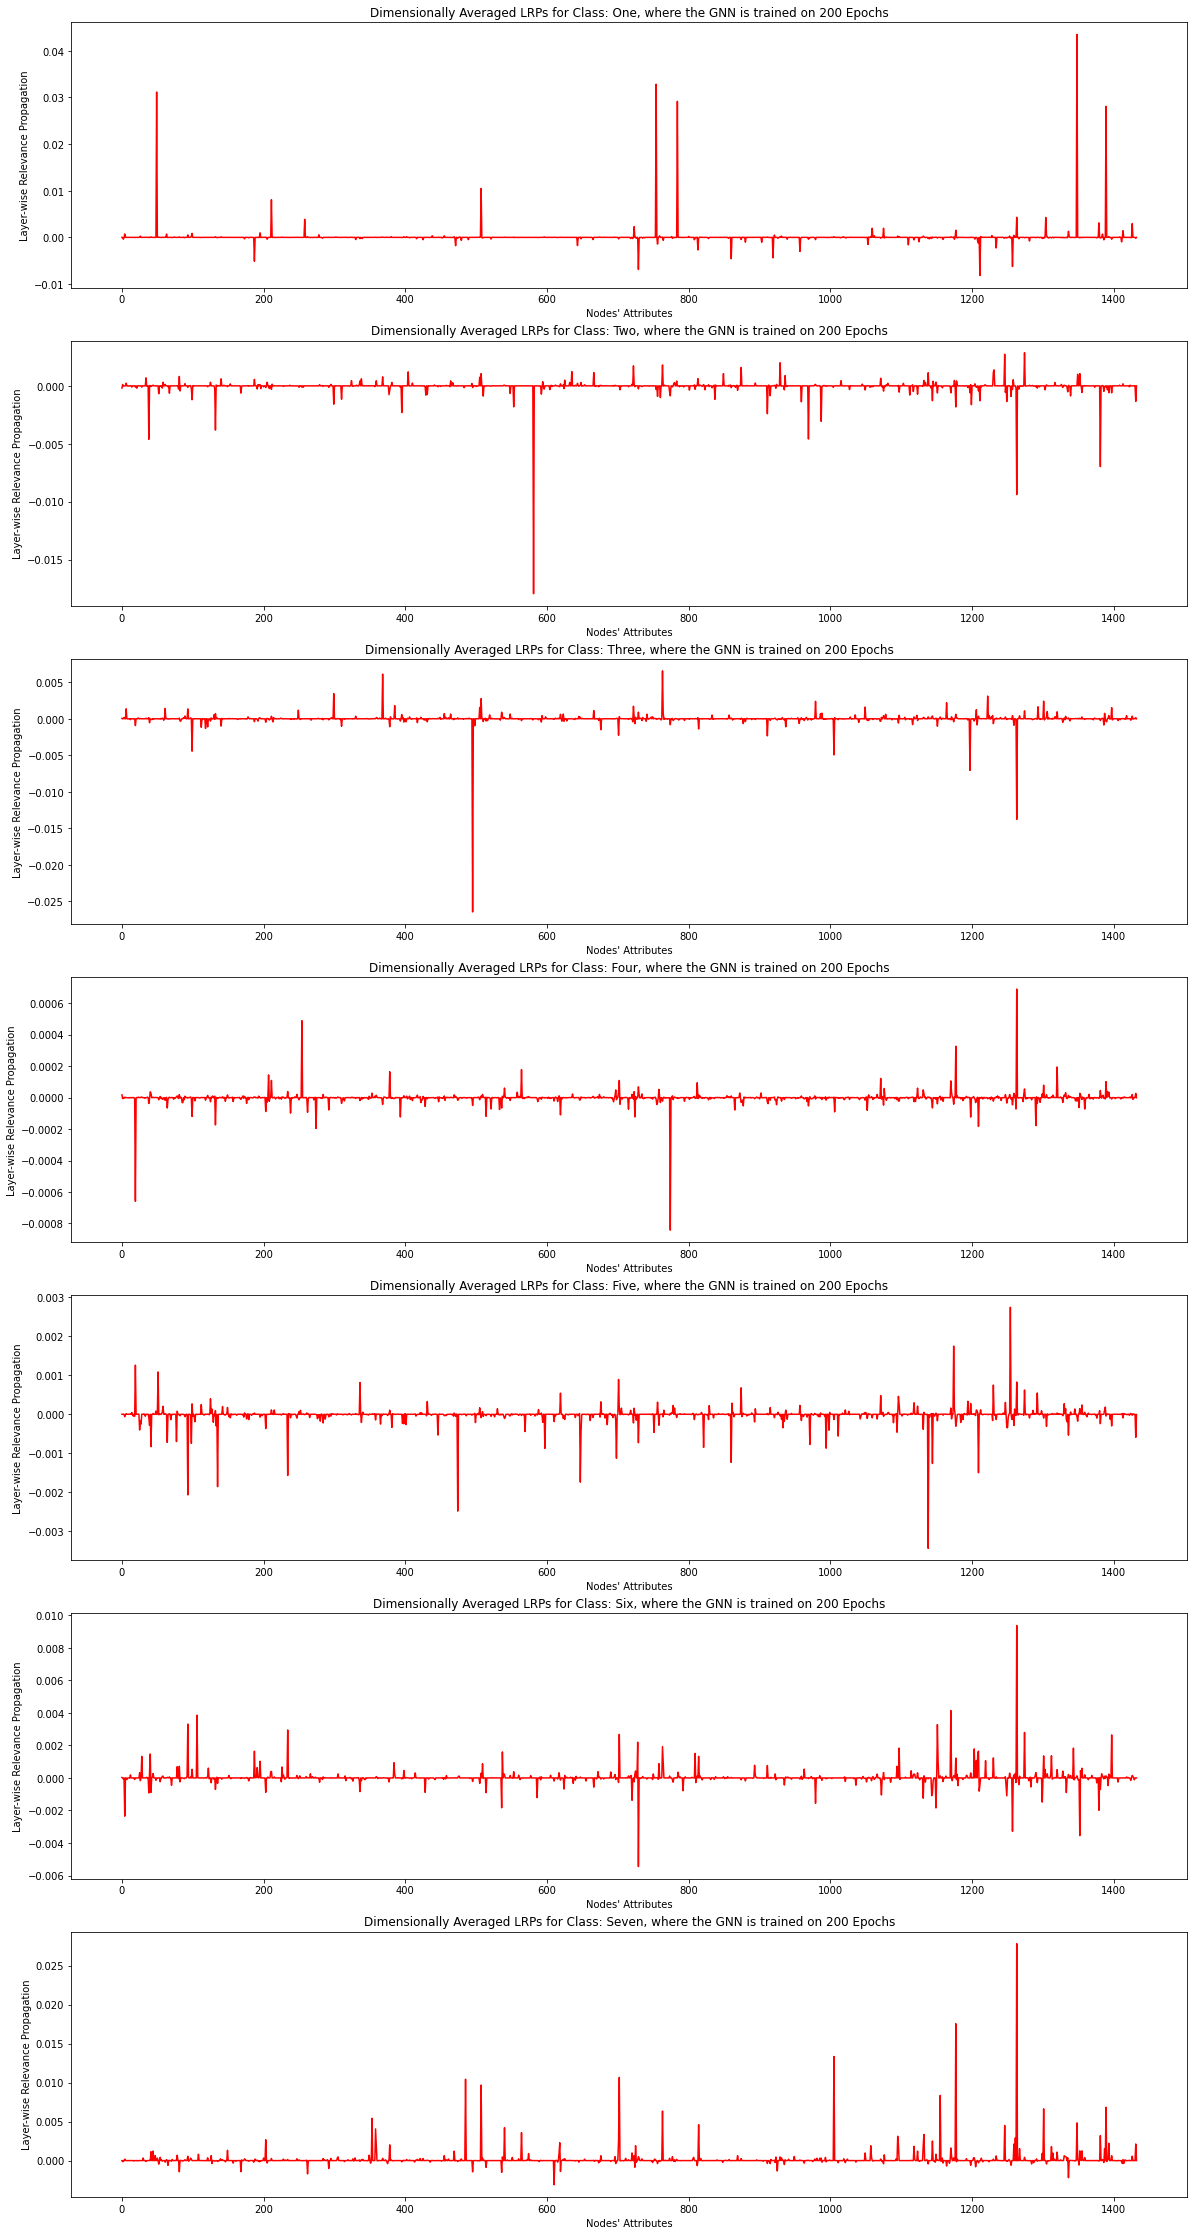

In [72]:
Averaged_LRP_Relevance_Classes([Average_LRPs_Class1, Average_LRPs_Class2, Average_LRPs_Class3, Average_LRPs_Class4, Average_LRPs_Class5, Average_LRPs_Class6, Average_LRPs_Class7])